In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import glob
import tensorflow.keras.datasets.mnist as mnist

In [2]:
(train_image, train_label), (_, _) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [3]:
train_image.shape

(60000, 28, 28)

In [4]:
train_label.shape

(60000,)

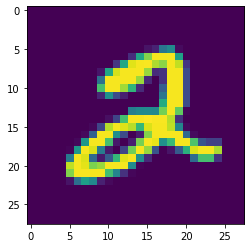

In [5]:
plt.imshow(train_image[5])

In [6]:
train_image = train_image / 127.5  - 1

In [7]:
train_image = np.expand_dims(train_image, -1)

In [8]:
train_image.shape

(60000, 28, 28, 1)

In [9]:
dataset = tf.data.Dataset.from_tensor_slices((train_image, train_label))

2022-06-29 16:28:50.970253: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [11]:
dataset

<TensorSliceDataset shapes: ((28, 28, 1), ()), types: (tf.float64, tf.uint8)>

In [12]:
BATCH_SIZE = 256
image_count = train_image.shape[0]
noise_dim = 50

In [13]:
dataset = dataset.shuffle(image_count).batch(BATCH_SIZE)

In [14]:
def generator_model():
    seed = layers.Input(shape=((noise_dim,)))
    label = layers.Input(shape=(()))
    
    x = layers.Embedding(10, 50, input_length=1)(label)
    x = layers.Flatten()(x)
    x = layers.concatenate([seed, x])
    x = layers.Dense(3*3*128, use_bias=False)(x)
    x = layers.Reshape((3, 3, 128))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)     #  7*7

    x = layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)    #   14*14

    x = layers.Conv2DTranspose(1, (3, 3), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.Activation('tanh')(x)
    
    model = tf.keras.Model(inputs=[seed,label], outputs=x)  
    
    return model

In [15]:
def discriminator_model():
    image = tf.keras.Input(shape=((28,28,1)))
    
    x = layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same', use_bias=False)(image)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Conv2D(32*2, (3, 3), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Conv2D(32*4, (3, 3), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Flatten()(x)
    x1 = layers.Dense(1)(x)
    x2 = layers.Dense(10)(x)
    
    model = tf.keras.Model(inputs=image, outputs=[x1, x2])
    return model

In [16]:
generator = generator_model()
discriminator = discriminator_model()

In [17]:
binary_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
category_cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [18]:
def discriminator_loss(real_output, real_cat_out, fake_output, label):
    real_loss = binary_cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = binary_cross_entropy(tf.zeros_like(fake_output), fake_output)
    cat_loss = category_cross_entropy(label, real_cat_out)
    total_loss = real_loss + fake_loss + cat_loss
    return total_loss

In [19]:
def generator_loss(fake_output, fake_cat_out, label):
    fake_loss = binary_cross_entropy(tf.ones_like(fake_output), fake_output)
    cat_loss = category_cross_entropy(label, fake_cat_out)
    return fake_loss + cat_loss

In [20]:
generator_optimizer = tf.keras.optimizers.Adam(1e-5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-5)

In [21]:
@tf.function
def train_step(images, labels):
    batchsize = labels.shape[0]
    noise = tf.random.normal([batchsize, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator((noise, labels), training=True)

        real_output, real_cat_out = discriminator(images, training=True)
        fake_output, fake_cat_out = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output, fake_cat_out, labels)
        disc_loss = discriminator_loss(real_output, real_cat_out, fake_output, labels)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [22]:
noise_dim = 50
num = 10
noise_seed = tf.random.normal([num, noise_dim])
cat_seed = np.random.randint(0, 10, size=(num, 1))
print(cat_seed.T)

[[8 7 4 2 8 9 7 6 2 0]]


In [23]:
def generate_and_save_images(model, test_noise_input, test_cat_input, epoch):
    print('Epoch:', epoch+1)
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    predictions = model((test_noise_input, test_cat_input), training=False)
    predictions = tf.squeeze(predictions)
    fig = plt.figure(figsize=(10, 1))

    for i in range(predictions.shape[0]):
        plt.subplot(1, 10, i+1)
        plt.imshow((predictions[i, :, :] + 1)/2, cmap='gray')
        plt.axis('off')

#    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [24]:
def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch, label_batch in dataset:
            train_step(image_batch, label_batch)
        if epoch%10 == 0:
            generate_and_save_images(generator,
                                     noise_seed,
                                     cat_seed,
                                     epoch)


    generate_and_save_images(generator,
                            noise_seed,
                            cat_seed,
                            epoch)

In [25]:
EPOCHS = 200

2022-06-29 16:28:54.102541: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch: 1


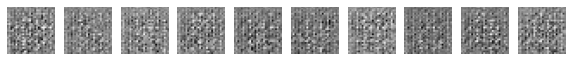

Epoch: 11


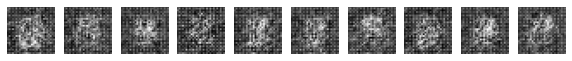

Epoch: 21


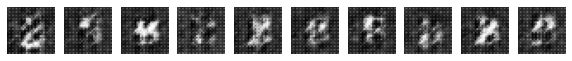

Epoch: 31


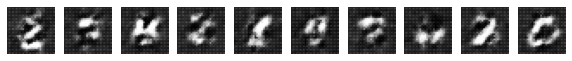

Epoch: 41


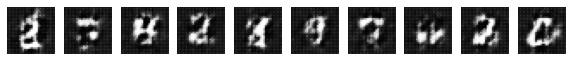

Epoch: 51


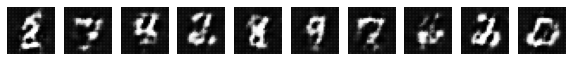

Epoch: 61


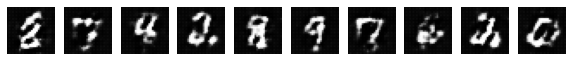

Epoch: 71


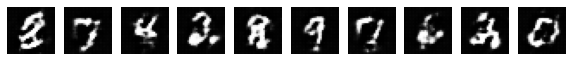

Epoch: 81


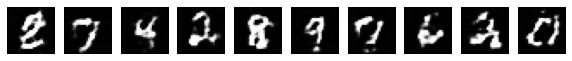

Epoch: 91


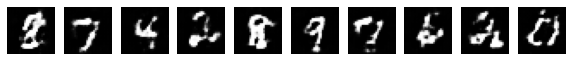

Epoch: 101


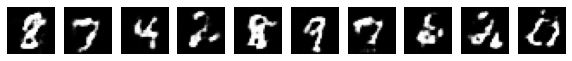

Epoch: 111


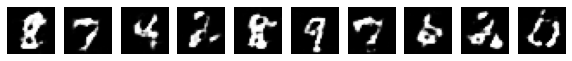

Epoch: 121


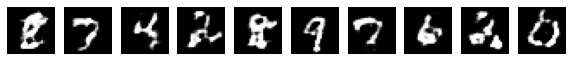

Epoch: 131


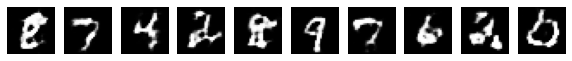

Epoch: 141


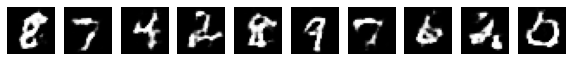

Epoch: 151


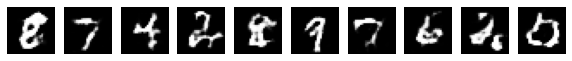

Epoch: 161


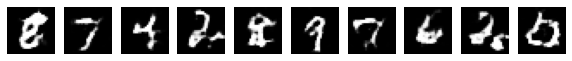

Epoch: 171


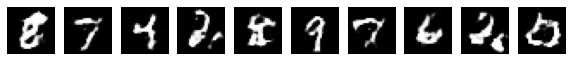

Epoch: 181


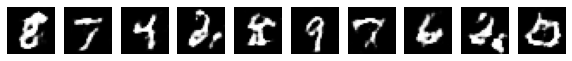

Epoch: 191


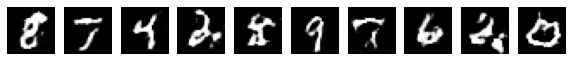

Epoch: 200


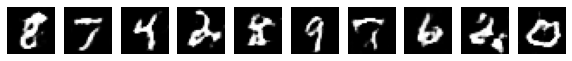

In [26]:
train(dataset, EPOCHS)

In [27]:
generator.save('generate_acgan.h5')

In [28]:
num = 10
noise_seed = tf.random.normal([num, noise_dim])
cat_seed = np.arange(10).reshape(-1, 1)
print(cat_seed.T)

[[0 1 2 3 4 5 6 7 8 9]]


Epoch: 2


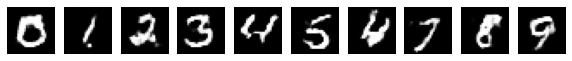

In [29]:
generate_and_save_images(generator, noise_seed, cat_seed, 1)

Epoch: 1


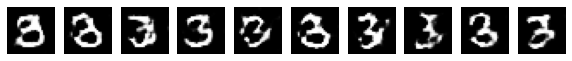

In [30]:
cat_seed = np.array([3]*10)
generate_and_save_images(generator, noise_seed, cat_seed, 0)

Epoch: 1


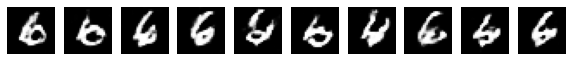

In [31]:
cat_seed = np.array([6]*10)
generate_and_save_images(generator, noise_seed, cat_seed, 0)